In [40]:
import constants # to use the constants defined in the constants.py file
import os
from google import genai # to use the GenAI API
from pydantic import BaseModel# to enforce a .JSON output schema to the model
from ultralytics import YOLO
import supervision as sv
import cv2

In [41]:
import numpy as np
import matplotlib.pyplot as plt  # For displaying images

# Step 1: Load the all th results images
image_dir_path = 'Images/Results'

image_paths = []

for filename in os.listdir(image_dir_path):
    if (filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".webp")) and filename.startswith("fire"):
        image_path = os.path.join(image_dir_path, filename)
        image_paths.append(image_path)
        
image_paths.sort()  # Sort the image paths to ensure consistent order

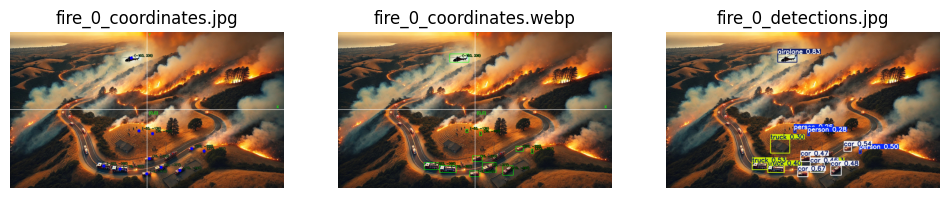

In [42]:
titles=[
    os.path.basename(image_path)
    for image_path in image_paths[:len(image_paths)]
    ]               

images = [
    cv2.imread(str(image_path))
    for image_path in image_paths[:len(image_paths)]
    ]

sv.plot_images_grid(images=images, titles=titles,grid_size=(1,3))

In [43]:
print(image_paths)

['Images/Results/fire_0_coordinates.jpg', 'Images/Results/fire_0_coordinates.webp', 'Images/Results/fire_0_detections.jpg']


In [44]:
client = genai.Client(api_key=constants.API_KEY)
model_name="gemini-2.5-pro-exp-03-25"

llm_image=client.files.upload(file=image_paths[1])
print(f"Image uploaded: {llm_image}")

llm_coordinates=client.files.upload(file="object_coordinates.txt")
print(f"Coordinates uploaded: {llm_coordinates}")

Image uploaded: name='files/1f92k1izbdqc' display_name=None mime_type='image/webp' size_bytes=2334644 create_time=datetime.datetime(2025, 5, 4, 8, 33, 42, 680449, tzinfo=TzInfo(UTC)) expiration_time=datetime.datetime(2025, 5, 6, 8, 33, 42, 621316, tzinfo=TzInfo(UTC)) update_time=datetime.datetime(2025, 5, 4, 8, 33, 42, 680449, tzinfo=TzInfo(UTC)) sha256_hash='YzdjODExNmYwYmE4Mzk0M2NjNTViY2JkNTcwNmY1Mzk0OTZhMmVkN2UyODMwNWQ2OTJkNjg1YWI1NzczY2IxZQ==' uri='https://generativelanguage.googleapis.com/v1beta/files/1f92k1izbdqc' download_uri=None state=<FileState.ACTIVE: 'ACTIVE'> source=<FileSource.UPLOADED: 'UPLOADED'> video_metadata=None error=None
Coordinates uploaded: name='files/ne7970hos8pe' display_name=None mime_type='text/plain' size_bytes=1446 create_time=datetime.datetime(2025, 5, 4, 8, 33, 44, 509802, tzinfo=TzInfo(UTC)) expiration_time=datetime.datetime(2025, 5, 6, 8, 33, 44, 448885, tzinfo=TzInfo(UTC)) update_time=datetime.datetime(2025, 5, 4, 8, 33, 44, 509802, tzinfo=TzInfo(UTC

In [57]:
prompt = """
            You are a network engineer responsible for analyzing the feed you received from a drone and identify the needs of the users in the network.
            The image was pre-processed to identify the objects in the image and their coordinates. 
            Your role here is to analyze the detected objects and infer the needs of the users in the network. The output must be the throughput need per user in the network.
            For example, if a object or a group of objects are very close to a fire, one can infer that those users need a more reliable connection and might need to be prioritized and more probably need to transmit heavy data, such as streaming a video or an image.
            If the user in question does not appear to be in a througput demainding situation, then the user can be classified as low or medium throughput need, and the justification for this classification can be just a simple sentence, like "the user is not in a througput demanding situation" or "the user is not in a fire situation". 
            One example of this not througput demanding situation is when the user is not on a iminent dangerous situation like a support firetruck  that is further away from the fire, or a user that is not in a fire situation at all.
            Also you are given a .txt file under the name "object_coordinates.txt" that contains the coordinates of the objects detected in the image, which are also present in the image.
            The output must be a JSON object with the following schema, this must be replicated for each user in the image:
            {
                total_users: 1, # the total number of users in the image, can more easily be obtained from the object_coordinates.txt file
                "user": [
                    {
                        "label": "user_label", # this label can be found in the object_coordinates.txt file and is corresponding to the coordinates associated with the user
                        "x": 0.0, # the x coordinate of the user in the image, that his associated with the label
                        "y": 0.0, # the y coordinate of the user in the image, that his associated with the label
                        "throughput_need": "high", # the throughput need of the user, can be "high", "medium" or "low"
                        "througput_justification": "the justification of the throughput need of the user, can be "high", "medium" or "low"
                        "throughput_example_value": 100.0
                    }
                ]
            }         
        """

# class User(BaseModel):
#     label: str
#     x: float
#     y: float
#     throughput_need: str
#     throughput_value: float

# class GenAIResponse(BaseModel):
#     users: list[User]

In [59]:
response = client.models.generate_content(
    model=model_name,
    contents=[llm_image, llm_coordinates, prompt],
    # config=genai.types.GenerateContentConfig(
    #     response_schema=GenAIResponse.model_json_schema(),
    #     )
    )

print(response.text)

```json
{
    "total_users": 11,
    "user": [
        {
            "label": "airplane",
            "x": -103,
            "y": 336,
            "throughput_need": "high",
            "througput_justification": "Helicopter likely performing aerial reconnaissance or water drops over an active fire zone, requiring reliable, high-bandwidth communication for video streaming and coordination.",
            "throughput_example_value": 10.0
        },
        {
            "label": "car",
            "x": -2,
            "y": -419,
            "throughput_need": "high",
            "througput_justification": "Emergency vehicle part of a convoy positioned very close to the active fire line, likely needing reliable communication for coordination and potentially transmitting situational data.",
            "throughput_example_value": 5.0
        },
        {
            "label": "car",
            "x": 292,
            "y": -255,
            "throughput_need": "medium",
            "througput_

In [60]:
with open("Results/prompt_response_pair.txt", "a") as file:
    file.write("Prompt:\n")
    file.write(prompt)
    file.write("\n\nResponse:\n")
    file.write(response.candidates[0].content.parts[0].text)
    file.write("\n\n======================================================================================================\n")
    file.close()